#### The goal of this project file is to predict nitrogen, phosphorus, and sediment concentrations at subwatersheds 11 and 12

#### There are three subsections:
a) Nitrogen prediction using total nitrogen <br>
b) Phosphorus prediction using total phosphorus <br>
c) Sediment prediction using total suspended solids

In [2]:
import pandas as pd
import math
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

#### Main nutrients dataset

In [27]:
df_main = pd.read_excel('2015-19 raw data.xlsx', sheet_name = 'By site')
df_main.head()

,Site,Start date,End date,Sample date,Collection method,Sample type,Flow (cms),NH3-N (mg N/L),DRP (mg P/L),NOx-N (mg N/L),TN (mg N/L),TP (mg P/L),TSS (mg/L),VSS (mg/L)
0,S11,2015-03-15,2015-03-20,2015-03-20,Grab,Base,0.0060,0.0137,0.020,50.9792,41.6,0.025,1.692308,1.230769
1,S11,2015-03-20,2015-03-27,2015-03-27,Grab,Base,0.0060,0.0042,0.020,48.7837,40.8,0.014,0.500000,0.500000
2,S11,2015-03-27,2015-04-03,2015-04-03,Grab,Base,0.0240,0.0056,0.001,45.4211,42.8,0.015,1.231527,1.970443
3,S11,2015-04-03,2015-04-11,2015-04-11,Grab,Base,0.0245,0.0174,0.012,46.5769,43.0,0.029,7.540395,6.642729
4,S11,2015-04-11,2015-04-17,2015-04-17,Grab,Base,0.0250,0.0166,0.001,48.2718,43.0,0.016,1.691729,0.500000


In [28]:
df_main = df_main.rename(columns={'Flow (cms)':'Flow', 'NH3-N (mg N/L)':'NH3','DRP (mg P/L)':'DRP', 
                                  'TP (mg P/L)':'TP', 'NOx-N (mg N/L)':'NOx', 'TN (mg N/L)':'TN', 'TSS (mg/L)':'TSS', 'VSS (mg/L)':'VSS'})
df_main.head()

,Site,Start date,End date,Sample date,Collection method,Sample type,Flow,NH3,DRP,NOx,TN,TP,TSS,VSS
0,S11,2015-03-15,2015-03-20,2015-03-20,Grab,Base,0.0060,0.0137,0.020,50.9792,41.6,0.025,1.692308,1.230769
1,S11,2015-03-20,2015-03-27,2015-03-27,Grab,Base,0.0060,0.0042,0.020,48.7837,40.8,0.014,0.500000,0.500000
2,S11,2015-03-27,2015-04-03,2015-04-03,Grab,Base,0.0240,0.0056,0.001,45.4211,42.8,0.015,1.231527,1.970443
3,S11,2015-04-03,2015-04-11,2015-04-11,Grab,Base,0.0245,0.0174,0.012,46.5769,43.0,0.029,7.540395,6.642729
4,S11,2015-04-11,2015-04-17,2015-04-17,Grab,Base,0.0250,0.0166,0.001,48.2718,43.0,0.016,1.691729,0.500000


In [29]:
df_main.describe()

,Flow,NH3,DRP,NOx,TN,TP,TSS,VSS
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,597.000000,597.000000
mean,0.064244,0.071287,0.042393,17.850073,19.308755,0.146001,77.559248,66.713845
std,0.094491,0.276394,0.138356,11.067543,11.405730,0.349803,508.889627,471.738103
min,0.000000,0.001200,0.001000,0.003000,0.250000,0.001500,0.500000,0.500000
25%,0.013738,0.002000,0.001000,9.200250,9.575825,0.019000,2.333333,1.333333
50%,0.030956,0.016600,0.008000,15.813000,17.368500,0.041000,8.666667,5.333333
75%,0.082303,0.062125,0.029000,24.867375,27.191500,0.116500,28.666667,22.000000
max,1.296460,4.898300,1.549000,50.979200,49.800000,4.709000,11166.000000,10454.000000


#### Auxiliary dataset
##### Factors that can be potentially used for predicting N concentration
- Daily precipitation
- Antecedent precipitation
- Seasonality
- Flow (likely low impact on NOx and TN)
- Temperature (likely low impact on NOx and TN)

In [30]:
df_weather = pd.read_excel('Weather data.xlsx', sheet_name = 'Weather')
df_weather.head()

,Date,ppt (mm),tmin (degrees C),tmean (degrees C),tmax (degrees C),tdmean (degrees C),vpdmin (hPa),vpdmax (hPa)
0,1981-01-01,0.0,-2.0,1.3,4.6,-2.1,0.56,2.91
1,1981-01-02,0.0,-11.2,-4.7,1.9,-8.1,0.27,3.29
2,1981-01-03,0.0,-14.6,-4.6,5.5,-10.3,0.33,5.59
3,1981-01-04,0.0,-15.1,-12.9,-10.7,-21.6,0.70,1.69
4,1981-01-05,0.0,-13.5,-10.5,-7.6,-20.9,1.01,2.39


### Section 1 - Nitrogen

In [31]:
# subsectioning nitrogen data
df_nitrogen = df_main.drop(columns=['DRP','TP', 'TSS', 'VSS'])
df_nitrogen.head()

,Site,Start date,End date,Sample date,Collection method,Sample type,Flow,NH3,NOx,TN
0,S11,2015-03-15,2015-03-20,2015-03-20,Grab,Base,0.0060,0.0137,50.9792,41.6
1,S11,2015-03-20,2015-03-27,2015-03-27,Grab,Base,0.0060,0.0042,48.7837,40.8
2,S11,2015-03-27,2015-04-03,2015-04-03,Grab,Base,0.0240,0.0056,45.4211,42.8
3,S11,2015-04-03,2015-04-11,2015-04-11,Grab,Base,0.0245,0.0174,46.5769,43.0
4,S11,2015-04-11,2015-04-17,2015-04-17,Grab,Base,0.0250,0.0166,48.2718,43.0


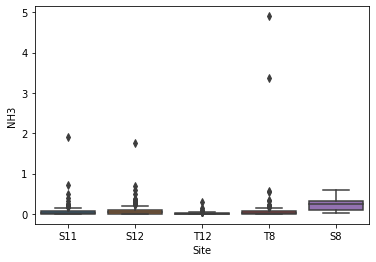

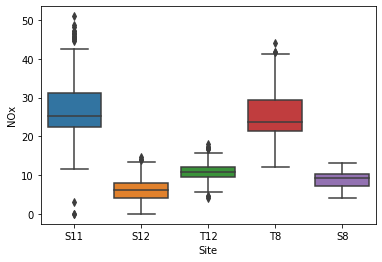

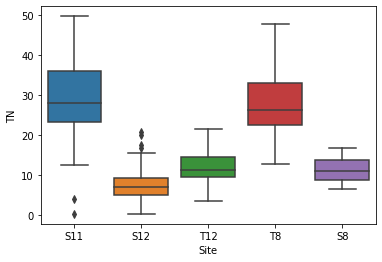

In [32]:
# visualizing N concentration distribution by sites
list_of_analytes = ['NH3', 'NOx', 'TN']

for x in list_of_analytes:
    ax = sns.boxplot(x='Site', y=x, data=df_nitrogen)
    plt.show()

In [33]:
# extract year and month from sample dates, then visualize the N concentration distribution by sites and years
df_nitrogen['Year'] = pd.DatetimeIndex(df_nitrogen['Sample date']).year
df_nitrogen['Month'] = pd.DatetimeIndex(df_nitrogen['Sample date']).month
df_nitrogen.head()

,Site,Start date,End date,Sample date,Collection method,Sample type,Flow,NH3,NOx,TN,Year,Month
0,S11,2015-03-15,2015-03-20,2015-03-20,Grab,Base,0.0060,0.0137,50.9792,41.6,2015,3
1,S11,2015-03-20,2015-03-27,2015-03-27,Grab,Base,0.0060,0.0042,48.7837,40.8,2015,3
2,S11,2015-03-27,2015-04-03,2015-04-03,Grab,Base,0.0240,0.0056,45.4211,42.8,2015,4
3,S11,2015-04-03,2015-04-11,2015-04-11,Grab,Base,0.0245,0.0174,46.5769,43.0,2015,4
4,S11,2015-04-11,2015-04-17,2015-04-17,Grab,Base,0.0250,0.0166,48.2718,43.0,2015,4


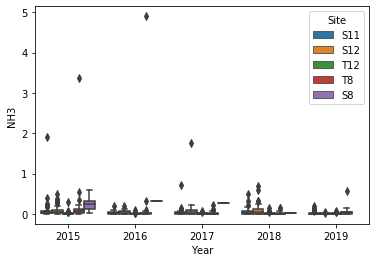

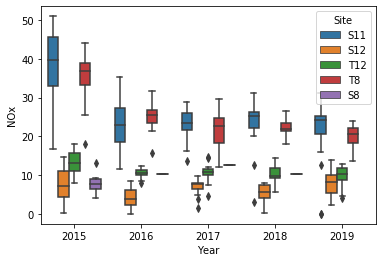

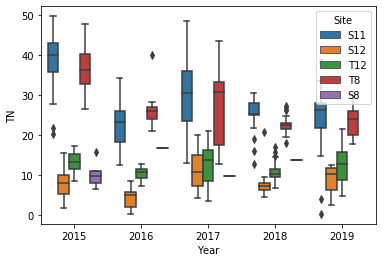

In [34]:
list_of_analytes = ['NH3', 'NOx', 'TN']

for x in list_of_analytes:
    ax = sns.boxplot(x='Year', y=x, data=df_nitrogen, hue='Site')
    plt.show()

In [35]:
# implement random forest
from sklearn.model_selection import train_test_split

# Use location, month, sample type, and flow to predict TN concentration
# other factors that can be used: sample date, year, etc. (see available data columns above)
# consider merging weather data (require to be pre-processed, such as calculating daily precip, antecedent precip, etc. - need to have same length as df_nitrogen dataset)
X = df_nitrogen[['Site', 'Month', 'Sample type', 'Flow']]

# setting TN concentration as the "target"
y = df_nitrogen['TN']

print (X.shape, y.shape)

(598, 4) (598,)


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.25, random_state = 0)
print(X_train.shape, Y_train.shape)

(448, 4) (448,)


In [37]:
reg = ske.RandomForestRegressor(n_estimators = 1000, random_state = 0)

In [38]:
# transform string data (i.e., site and sample type) into incremental value using label encoder
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for i in range(len(X_train)):
    X_train[['Site','Sample type']]= X_train[['Site','Sample type']].apply(le.fit_transform)
    X_test[['Site','Sample type']]= X_test[['Site','Sample type']].apply(le.fit_transform)


C:\Users\jiyeow\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [15]:
reg.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [16]:
Y_pred = reg.predict(X_test)

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

print(explained_variance_score(Y_test, Y_pred))
print(mean_absolute_error(Y_test, Y_pred))
print(mean_squared_error(Y_test, Y_pred))
print(r2_score(Y_test, Y_pred))
print(reg.feature_importances_)

0.7365878346665913
4.311318507436367
40.21411104056344
0.7324191066932051
[0.69687403 0.0861549  0.01225508 0.20471599]


In [22]:
fet_ind = np.argsort(reg.feature_importances_)[::-1]
fet_imp = reg.feature_importances_[np.argsort(reg.feature_importances_)][::-1]

Text(0.5, 1.0, 'Feature importance')

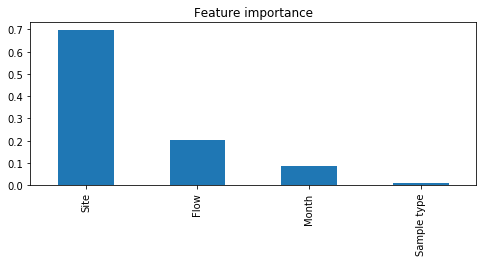

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))
labels = np.asarray(X_train.columns[fet_ind])
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Feature importance')

Text(0, 0.5, 'NOx conc')

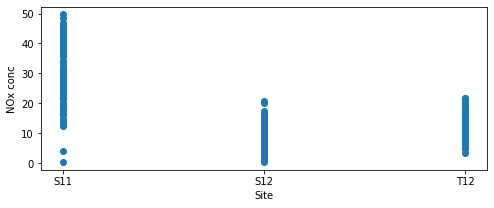

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.scatter(X['Site'],y)
ax.set_xlabel('Site')
ax.set_ylabel('NOx conc')